In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"





In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )

print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium poor
#resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5


use_poisson_fluctuations_around_ngen_true = True
#use_poisson_fluctuations_around_ngen_true = False


do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-3b'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.10

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 5


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.1,
 'window_nbins': 5}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)


this_ngen_true = ngen_true
if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )

true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)




train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( this_ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.59571523]
 [-0.87020263]
 [-0.76158324]
 ...
 [-0.04177346]
 [-0.58972347]
 [-0.78800651]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )




config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-3c/config.txt

2024-08-08 08:33:24.356782

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
use_poisson_fluctuations_around_total : False


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [1e-06]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

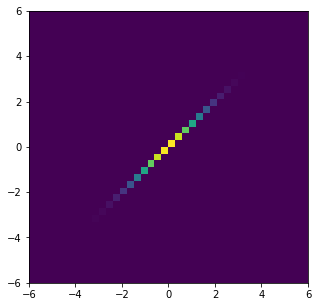

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

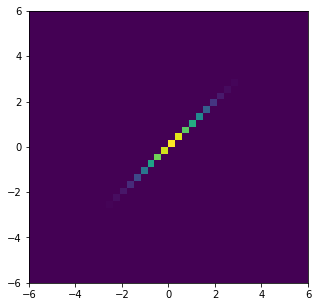

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

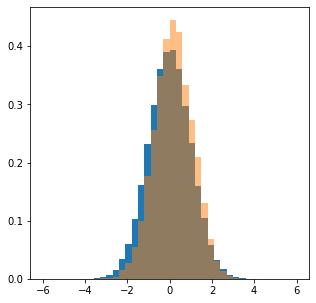

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.59571523]
 [-0.87020263]
 [-0.76158324]
 ...
 [-0.04177346]
 [-0.58972347]
 [-0.78800651]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.79571523]
 [-1.07020263]
 [-0.96158324]
 ...
 [-0.24177346]
 [-0.78972347]
 [-0.98800651]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.4724595  0.38635786 0.4221606  ... 0.56369754 0.47414039 0.41360574]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.42407472 0.30912779 0.35424331 ... 0.60466095 0.42656877 0.34315591]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( this_ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.188
  cov f0f0 :   0.8097
  sigma f0 :   0.8998


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.188
  cov f0f0 :   0.8097
  sigma f0 :   0.8998


In [45]:
test_calc_true_model

{'mean': array([0.18831233]), 'cov': array([[0.80967198]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.89758958, 0.80010744, 0.83911976, ..., 1.07266913, 0.89966765,
       0.82966911])

In [49]:
pdf_ratio

array([0.89758958, 0.80010744, 0.83911976, ..., 1.07266913, 0.89966765,
       0.82966911])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( this_ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([0.89758958, 0.80010744, 0.83911976, ..., 1.07266913, 0.89966765,
       0.82966911])

In [54]:
calc_weight

array([0.89758958, 0.80010744, 0.83911976, ..., 1.07266913, 0.89966765,
       0.82966911])

In [55]:
test_hist_pdf_ratio

array([0.86976183, 0.84379616, 0.85832472, ..., 1.08952381, 0.86976183,
       0.87780899])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -0.596   true   0.8976  from hist  0.8698
   1   x  -0.870   true   0.8001  from hist  0.8438
   2   x  -0.762   true   0.8391  from hist  0.8583
   3   x  -0.740   true   0.8470  from hist  0.8668
   4   x  -0.476   true   0.9385  from hist  0.9235
   5   x   0.778   true   1.2235  from hist  1.0999
   6   x   0.155   true   1.1231  from hist  1.1256
   7   x  -0.328   true   0.9871  from hist  1.0407
   8   x  -1.729   true   0.4982  from hist  0.4860
   9   x   0.830   true   1.2273  from hist  1.1060
  10   x   0.407   true   1.1755  from hist  1.1552
  11   x  -1.384   true   0.6152  from hist  0.5853
  12   x  -0.760   true   0.8396  from hist  0.8583
  13   x  -2.986   true   0.1822  from hist  0.0952
  14   x  -0.462   true   0.9434  from hist  0.9235
  15   x  -0.290   true   0.9991  from hist  1.0535
  16   x  -0.207   true   1.0249  from hist  1.0705
  17   x  -1.522   true   0.5673  from hist  0.5991
  18   x  -0.083   true   1.0611  from hist  1.0650
  19   x   1

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    of_ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = of_ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*of_ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    

    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        


        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( of_ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[0.86976183 0.84379616 0.85832472 ... 1.08952381 0.86976183 0.87780899]
  iter 1, step1_output_weights:  shape (100000,)
[0.86976183 0.84379616 0.85832472 ... 1.08952381 0.86976183 0.87780899]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.88085211 0.84311552 0.8640783  ... 1.07376762 0.88085211 0.85935374]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.88085211 0.84311552 0.8640783  ... 1.07376762 0.88085211 0.85935374]
 pdf_ratio_step1:  shape (100000,) 
[0.98258967 1.00828134 0.99833895 ... 1.01020993 0.98258967 1.02493304]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

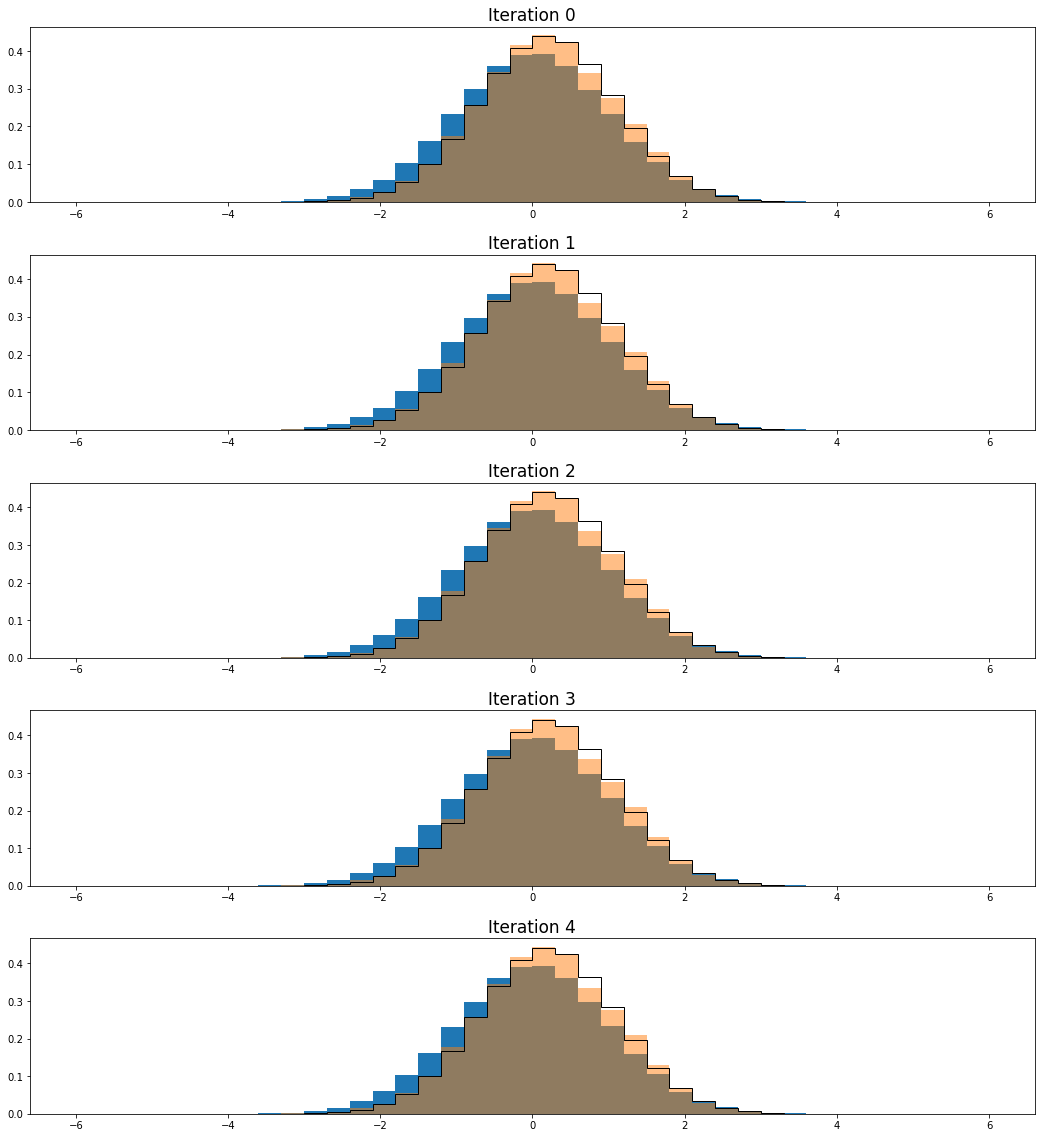

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

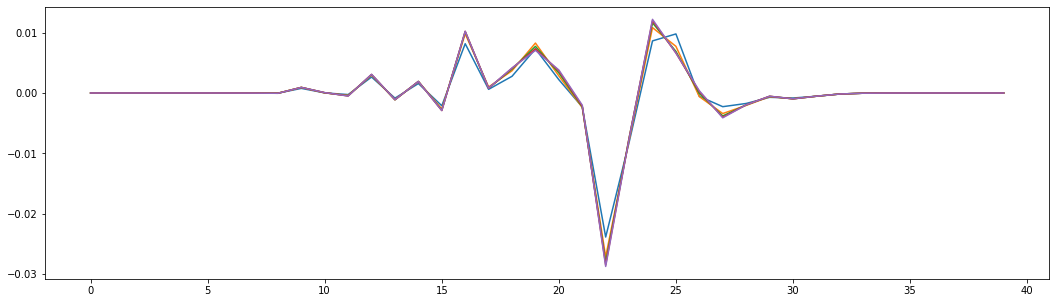

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

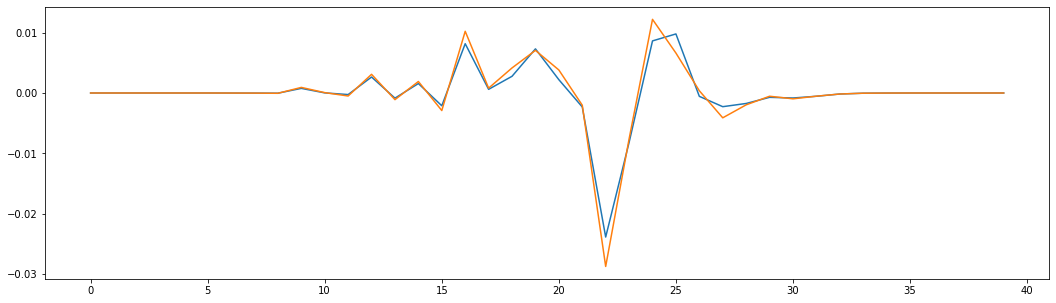

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

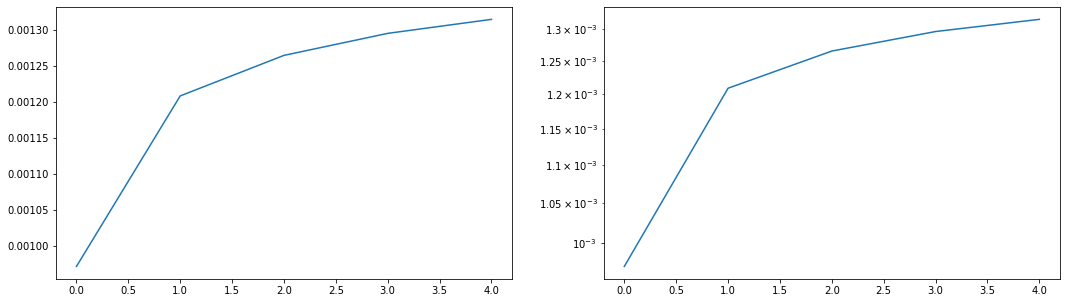

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

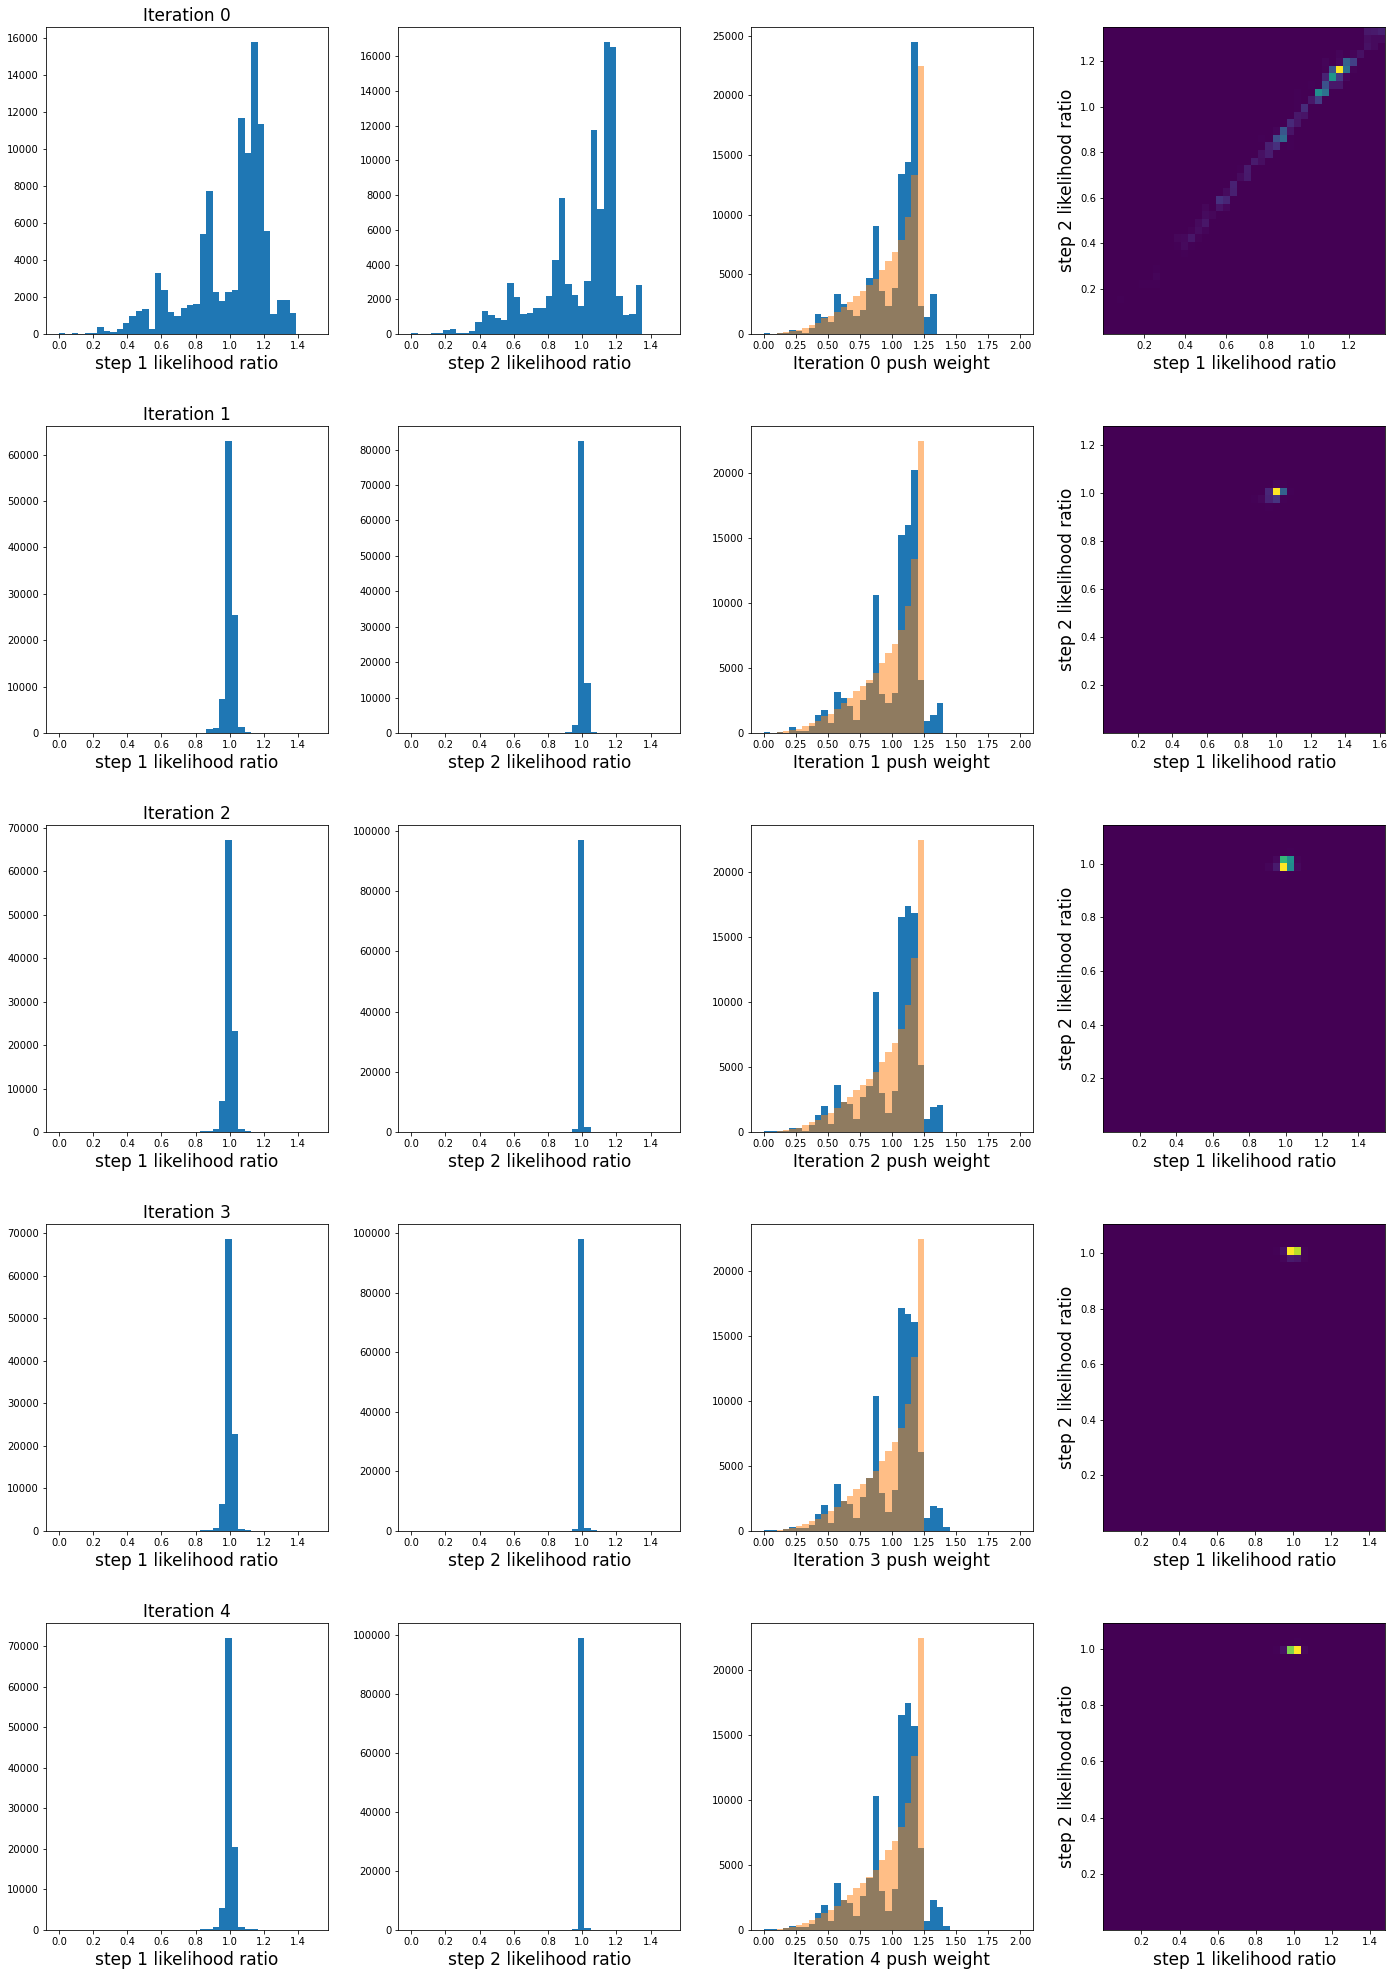

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

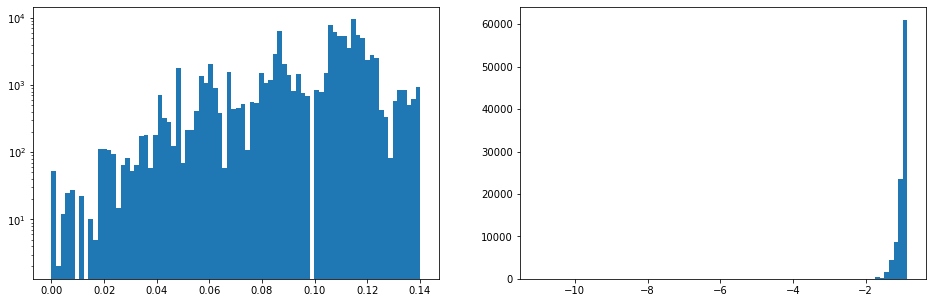

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

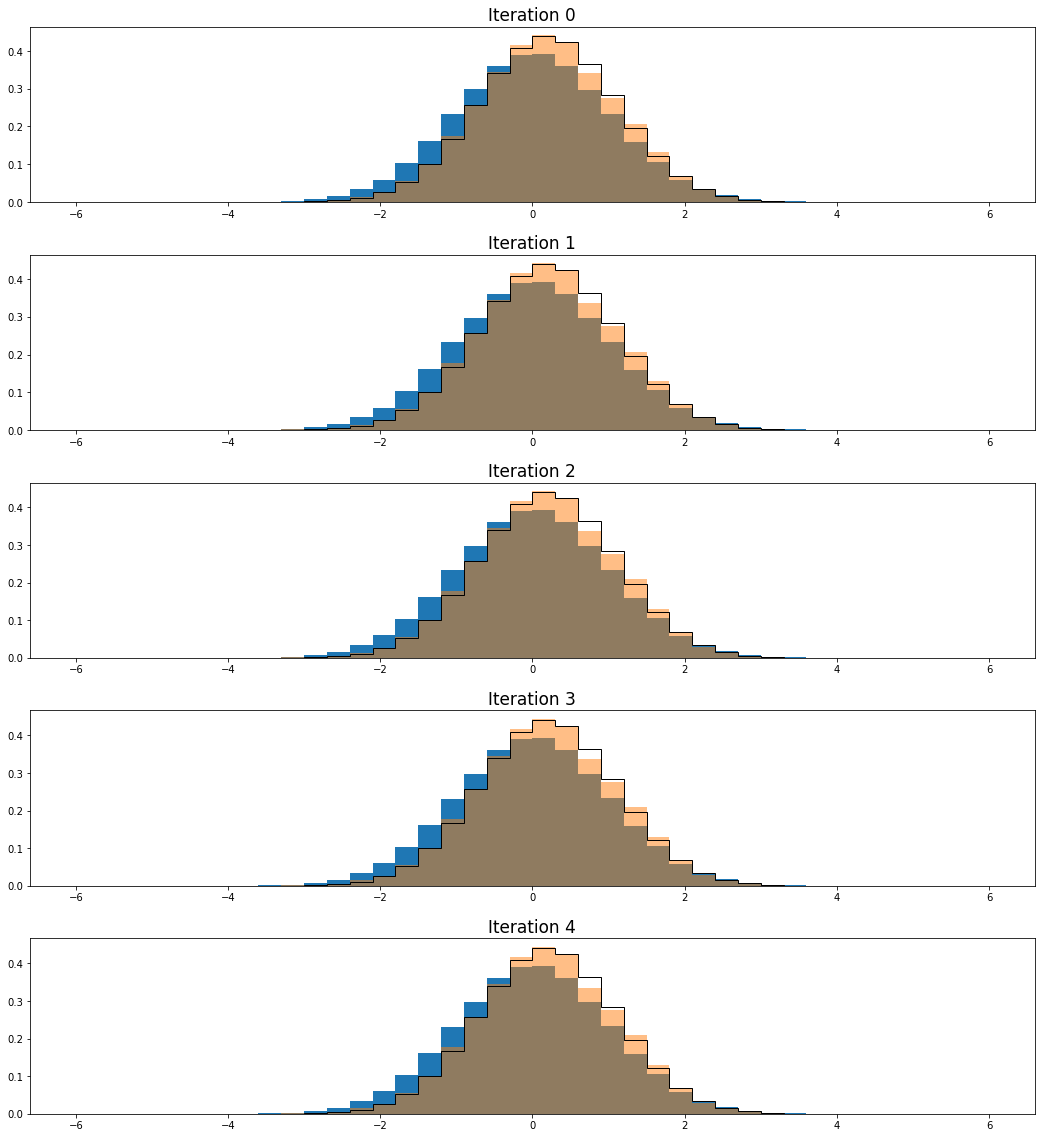

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

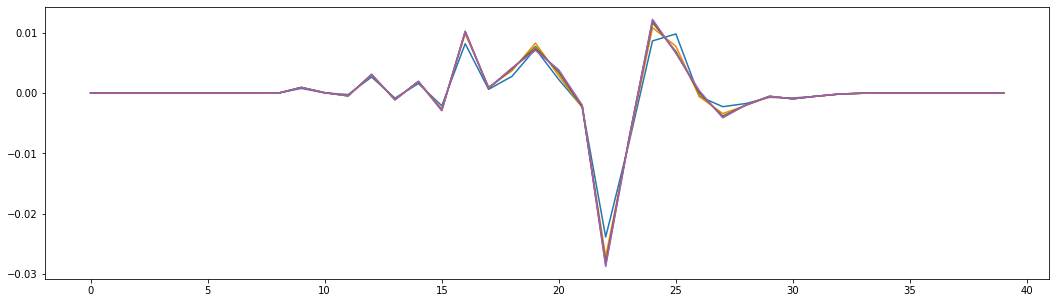

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

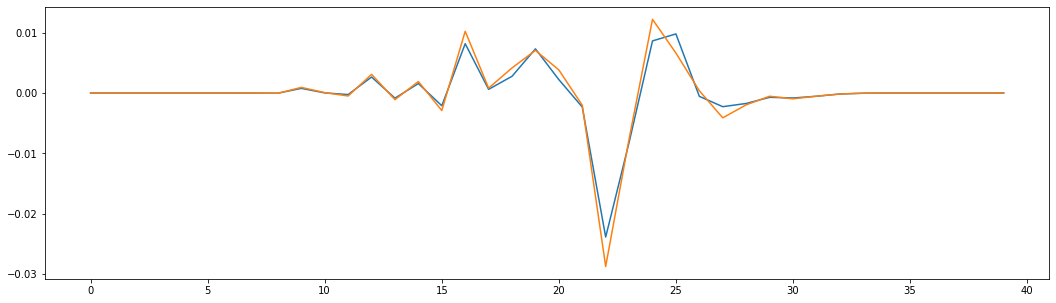

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

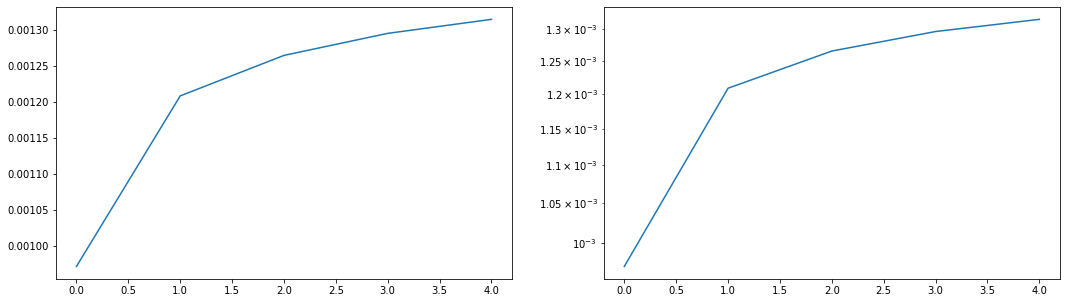

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.998  rms 0.229      step 2 mean  0.998  rms 0.228
  iter  1 : step 1 mean  0.999  rms 0.039      step 2 mean  1.000  rms 0.021
  iter  2 : step 1 mean  0.999  rms 0.035      step 2 mean  1.000  rms 0.017
  iter  3 : step 1 mean  0.999  rms 0.033      step 2 mean  1.000  rms 0.015
  iter  4 : step 1 mean  0.999  rms 0.032      step 2 mean  1.000  rms 0.014


<function matplotlib.pyplot.show(close=None, block=None)>

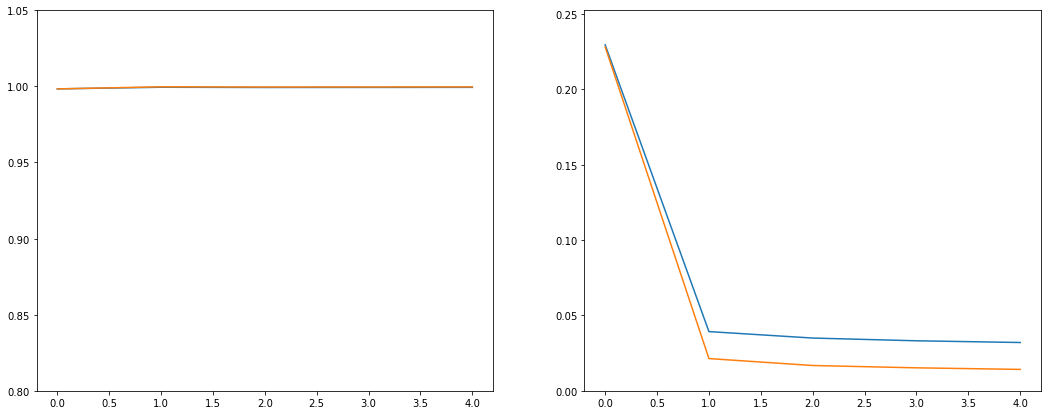

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

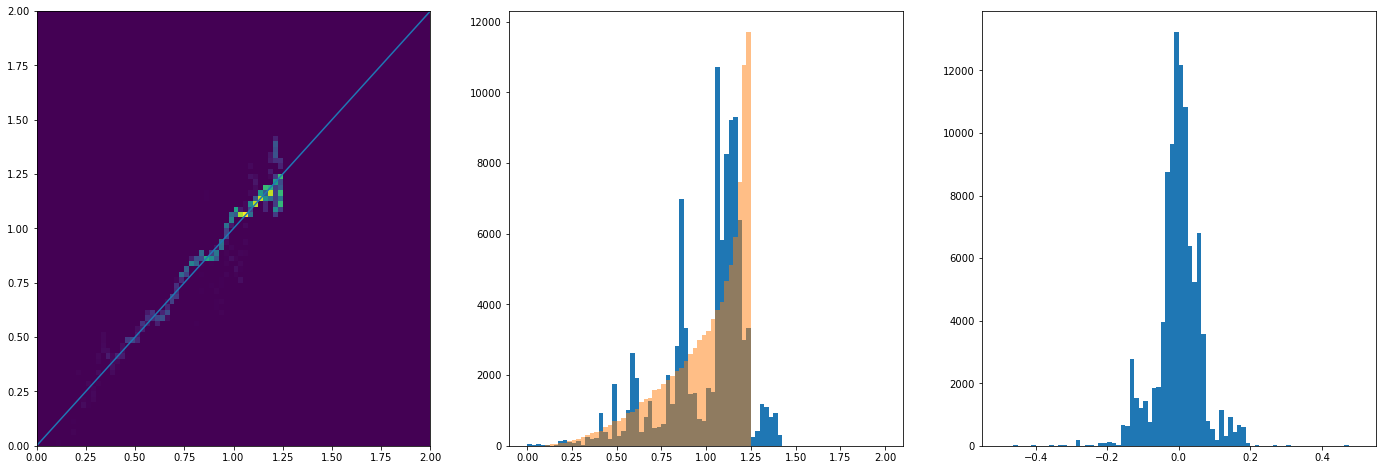

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.06375




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85281324 0.80064029 0.82709538 ... 1.06641332 0.85281324 0.82744676]
 weights_push at the beginning
[0.84642276 0.81893458 0.83419437 ... 1.05113196 0.84642276 0.84026715]
 weights_push at the beginning
[0.84417522 0.82626467 0.83369682 ... 1.03995359 0.84417522 0.84388511]
 weights_push at the beginning
[0.84438868 0.8314106  0.83228661 ... 1.03287927 0.84438868 0.84585085]


 bootstrap 0 final push weights scaled:
[0.084534   0.08361008 0.0830566  ... 0.10279442 0.084534   0.08471007]

 Creating toy sample   1,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89295261 0.77259297 0.80197976 ... 1.05273182 0.89295261 0.79482203]
 weights_push at the beginning
[0.90063477 0.76393307 0.79731548 ... 1.04802336 0.90063477 0.78963429]
 weights_push at the beginning
[0.90328674 0.75683483 0.


 Creating toy sample  13,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92585348 0.7699815  0.86279558 ... 1.07527218 0.92585348 0.840821  ]
 weights_push at the beginning
[0.92918179 0.7571534  0.88047239 ... 1.09392873 0.92918179 0.84997955]
 weights_push at the beginning
[0.92563761 0.7511371  0.8911676  ... 1.10449027 0.92563761 0.85510705]
 weights_push at the beginning
[0.9221392  0.74867192 0.89852738 ... 1.11182462 0.9221392  0.85823926]


 bootstrap 13 final push weights scaled:
[0.0919677  0.0747987  0.09038202 ... 0.11175171 0.0919677  0.08599795]

 Creating toy sample  14,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89424442 0.82216013 0.86185429 ... 1.06627346 0.89424442 0.85624581]
 weights_push at the beginning
[0.89181911 0.83066916 0.87050106 ... 1.06199024 0.89181911 0.86610869]
 weights_push at the beginning
[0.88939688 0.83168668 0


 Creating toy sample  27,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88740626 0.79972159 0.84078418 ... 1.04967771 0.88740626 0.83385152]
 weights_push at the beginning
[0.88324787 0.80294541 0.84917768 ... 1.04848249 0.88324787 0.84198834]
 weights_push at the beginning
[0.8792039  0.8027047  0.85392451 ... 1.04845916 0.8792039  0.84624209]
 weights_push at the beginning
[0.87658814 0.8034235  0.85800957 ... 1.04896372 0.87658814 0.84987711]


 bootstrap 27 final push weights scaled:
[0.0874847  0.08048102 0.08612118 ... 0.10493864 0.0874847  0.08526557]

 Creating toy sample  28,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86985615 0.8249384  0.86285753 ... 1.06302504 0.86985615 0.86633847]
 weights_push at the beginning
[0.86282294 0.84125353 0.8745259  ... 1.05656272 0.86282294 0.88757579]
 weights_push at the beginning
[0.86015575 0.84790349 0


 Creating toy sample  41,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89796871 0.79484308 0.85378568 ... 1.14745883 0.89796871 0.84505994]
 weights_push at the beginning
[0.89692366 0.79289176 0.8614279  ... 1.15662506 0.89692366 0.85375765]
 weights_push at the beginning
[0.89286619 0.78994894 0.86253543 ... 1.15252944 0.89286619 0.85704702]
 weights_push at the beginning
[0.8887172  0.78794448 0.86209025 ... 1.1472467  0.8887172  0.85931001]


 bootstrap 41 final push weights scaled:
[0.08847915 0.07869091 0.08610359 ... 0.1142447  0.08847915 0.08612616]

 Creating toy sample  42,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93190152 0.77601086 0.81104142 ... 1.06696715 0.93190152 0.80073266]
 weights_push at the beginning
[0.94991773 0.77389564 0.80376138 ... 1.05366462 0.94991773 0.79306381]
 weights_push at the beginning
[0.9572667  0.77275809 0


 Creating toy sample  55,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90117296 0.82790738 0.88419507 ... 1.08036175 0.90117296 0.87197449]
 weights_push at the beginning
[0.89631412 0.83512924 0.90131337 ... 1.08434535 0.89631412 0.88513535]
 weights_push at the beginning
[0.89216427 0.84010092 0.90991104 ... 1.08421526 0.89216427 0.89052268]
 weights_push at the beginning
[0.88989242 0.84579217 0.91557897 ... 1.08408322 0.88989242 0.89335196]


 bootstrap 55 final push weights scaled:
[0.08888447 0.08518303 0.09194883 ... 0.10841427 0.08888447 0.08945792]

 Creating toy sample  56,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86574287 0.75952096 0.79030175 ... 1.10652751 0.86574287 0.78303083]
 weights_push at the beginning
[0.87773433 0.75818458 0.78767143 ... 1.11057295 0.87773433 0.78046537]
 weights_push at the beginning
[0.88414427 0.75770877 0


 Creating toy sample  69,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87009776 0.81647946 0.841524   ... 1.0360224  0.87009776 0.84323047]
 weights_push at the beginning
[0.86459984 0.8181035  0.84249465 ... 1.03132113 0.86459984 0.85036516]
 weights_push at the beginning
[0.8616095  0.81932876 0.84125794 ... 1.02726403 0.8616095  0.85507547]
 weights_push at the beginning
[0.85995958 0.82053333 0.83870049 ... 1.02416205 0.85995958 0.85822703]


 bootstrap 69 final push weights scaled:
[0.08590502 0.08214378 0.08352505 ... 0.10213394 0.08590502 0.0860188 ]

 Creating toy sample  70,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89934159 0.6864867  0.77046078 ... 1.11807122 0.89934159 0.75024639]
 weights_push at the beginning
[0.91272878 0.67053315 0.77813027 ... 1.13275738 0.91272878 0.75221656]
 weights_push at the beginning
[0.91356614 0.66540077 0


 Creating toy sample  83,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89044766 0.83026769 0.86146257 ... 1.00240097 0.89044766 0.85727069]
 weights_push at the beginning
[0.87760479 0.83035926 0.86670702 ... 0.97816269 0.87760479 0.86323902]
 weights_push at the beginning
[0.86901939 0.82892832 0.87057218 ... 0.96588275 0.86901939 0.86767318]
 weights_push at the beginning
[0.8629611  0.82859245 0.87376586 ... 0.95815863 0.8629611  0.87166659]


 bootstrap 83 final push weights scaled:
[0.0858315  0.08291273 0.08760342 ... 0.09522074 0.0858315  0.08749634]

 Creating toy sample  84,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86480171 0.77335773 0.81906103 ... 1.05690165 0.86480171 0.80719889]
 weights_push at the beginning
[0.86133775 0.76449856 0.82239396 ... 1.05585606 0.86133775 0.80643477]
 weights_push at the beginning
[0.85735345 0.75830783 0


 Creating toy sample  97,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88653499 0.80293341 0.85908748 ... 1.05291541 0.88653499 0.84580597]
 weights_push at the beginning
[0.88528064 0.80651573 0.87140895 ... 1.04730702 0.88528064 0.85397458]
 weights_push at the beginning
[0.88380313 0.80962474 0.87623998 ... 1.04224037 0.88380313 0.85598543]
 weights_push at the beginning
[0.88346884 0.81344055 0.87858192 ... 1.03921843 0.88346884 0.85616011]


 bootstrap 97 final push weights scaled:
[0.08838478 0.0817569  0.08797637 ... 0.10372482 0.08838478 0.08555204]

 Creating toy sample  98,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88862267 0.81418102 0.80721271 ... 1.06685656 0.88862267 0.81016404]
 weights_push at the beginning
[0.89526758 0.81366986 0.79690125 ... 1.06314721 0.89526758 0.80402932]
 weights_push at the beginning
[0.89971237 0.81241575 0


 Creating toy sample 111,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88188341 0.78831119 0.82586757 ... 1.0555101  0.88188341 0.81855066]
 weights_push at the beginning
[0.87829843 0.79014765 0.83289119 ... 1.05695417 0.87829843 0.82448772]
 weights_push at the beginning
[0.87484683 0.79190847 0.83831086 ... 1.05742947 0.87484683 0.82862916]
 weights_push at the beginning
[0.8727933  0.79388885 0.84248528 ... 1.05692913 0.8727933  0.83136983]


 bootstrap 111 final push weights scaled:
[0.08717851 0.07957626 0.08455299 ... 0.10556024 0.08717851 0.08328289]

 Creating toy sample 112,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89937232 0.73728744 0.77558714 ... 1.07522784 0.89937232 0.76689993]
 weights_push at the beginning
[0.91114133 0.73823657 0.77077881 ... 1.07425317 0.91114133 0.76333785]
 weights_push at the beginning
[0.91510632 0.74131543 


 Creating toy sample 125,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88617477 0.79738841 0.86610343 ... 1.01723379 0.88617477 0.85523821]
 weights_push at the beginning
[0.87497254 0.79916258 0.88791532 ... 1.02948874 0.87497254 0.8748572 ]
 weights_push at the beginning
[0.86537558 0.79908101 0.90169634 ... 1.04025991 0.86537558 0.88691281]
 weights_push at the beginning
[0.85889166 0.79909668 0.91199683 ... 1.04793143 0.85889166 0.8956858 ]


 bootstrap 125 final push weights scaled:
[0.08545789 0.07993647 0.09200806 ... 0.10532109 0.08545789 0.09023658]

 Creating toy sample 126,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91132887 0.79584168 0.80157678 ... 1.09657556 0.91132887 0.79738133]
 weights_push at the beginning
[0.92211248 0.80037544 0.7896664  ... 1.11110737 0.92211248 0.78664208]
 weights_push at the beginning
[0.92600624 0.80271115 


 Creating toy sample 139,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89257445 0.80287138 0.82992393 ... 1.08523423 0.89257445 0.82715359]
 weights_push at the beginning
[0.88768012 0.8085032  0.83351331 ... 1.08657903 0.88768012 0.83349096]
 weights_push at the beginning
[0.88295411 0.80943529 0.83596866 ... 1.0881651  0.88295411 0.83778929]
 weights_push at the beginning
[0.87952519 0.80999118 0.83879186 ... 1.0894717  0.87952519 0.84217582]


 bootstrap 139 final push weights scaled:
[0.08767141 0.08105389 0.08414211 ... 0.10900741 0.08767141 0.08462935]

 Creating toy sample 140,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86154139 0.7562786  0.80008475 ... 1.00260969 0.86154139 0.79024104]
 weights_push at the beginning
[0.86195936 0.74795907 0.80247729 ... 0.99770413 0.86195936 0.79060076]
 weights_push at the beginning
[0.85973215 0.74490081 


 Creating toy sample 153,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92590009 0.68756662 0.77840217 ... 1.10422194 0.92590009 0.75549301]
 weights_push at the beginning
[0.94363229 0.66876901 0.78627889 ... 1.1156534  0.94363229 0.75619183]
 weights_push at the beginning
[0.94719489 0.66124813 0.79315277 ... 1.12105598 0.94719489 0.75896625]
 weights_push at the beginning
[0.94811625 0.65829249 0.79855614 ... 1.12416532 0.94811625 0.76152668]


 bootstrap 153 final push weights scaled:
[0.09487474 0.06570352 0.08025056 ... 0.11259885 0.09487474 0.07631686]

 Creating toy sample 154,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89851279 0.80666254 0.83425346 ... 1.06422207 0.89851279 0.82748028]
 weights_push at the beginning
[0.90531588 0.80181595 0.83049263 ... 1.06191324 0.90531588 0.82323234]
 weights_push at the beginning
[0.9086519  0.79881837 


 Creating toy sample 167,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.84622684 0.79109559 0.82557498 ... 1.05479795 0.84622684 0.82098356]
 weights_push at the beginning
[0.83481834 0.78963382 0.8300489  ... 1.0460606  0.83481834 0.82637288]
 weights_push at the beginning
[0.82766035 0.78741117 0.83208149 ... 1.04171945 0.82766035 0.82966554]
 weights_push at the beginning
[0.82235226 0.78634885 0.83311578 ... 1.04068816 0.82235226 0.83238882]


 bootstrap 167 final push weights scaled:
[0.08178667 0.07857511 0.08332886 ... 0.10409307 0.08178667 0.08345107]

 Creating toy sample 168,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89774984 0.85853839 0.86542504 ... 1.04144123 0.89774984 0.86872592]
 weights_push at the beginning
[0.89161734 0.87877557 0.86466116 ... 1.03413619 0.89161734 0.87460748]
 weights_push at the beginning
[0.88846443 0.88297613 


 Creating toy sample 181,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91068808 0.79492837 0.81204572 ... 1.04714562 0.91068808 0.80284625]
 weights_push at the beginning
[0.92505214 0.79703125 0.80448211 ... 1.04878828 0.92505214 0.79277822]
 weights_push at the beginning
[0.93266097 0.79822967 0.79955975 ... 1.0501324  0.93266097 0.78545425]
 weights_push at the beginning
[0.9373027  0.79962469 0.79706124 ... 1.05195629 0.9373027  0.78064338]


 bootstrap 181 final push weights scaled:
[0.09401225 0.08012556 0.07960832 ... 0.10540575 0.09401225 0.07774549]

 Creating toy sample 182,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87599641 0.82064551 0.8775439  ... 1.06054184 0.87599641 0.86752817]
 weights_push at the beginning
[0.86648415 0.8342607  0.89944879 ... 1.05574125 0.86648415 0.88702926]
 weights_push at the beginning
[0.86159287 0.84307888 


 Creating toy sample 195,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91478708 0.79599696 0.82958584 ... 1.08606114 0.91478708 0.82711759]
 weights_push at the beginning
[0.92346986 0.80551566 0.83162721 ... 1.09476892 0.92346986 0.83472958]
 weights_push at the beginning
[0.9271187  0.80820027 0.83024821 ... 1.09938444 0.9271187  0.83823756]
 weights_push at the beginning
[0.92970034 0.80883918 0.82955282 ... 1.10283306 0.92970034 0.84202471]


 bootstrap 195 final push weights scaled:
[0.09313929 0.08085259 0.0829594  ... 0.11056955 0.09313929 0.0846374 ]

 Creating toy sample 196,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89801976 0.81712061 0.87263398 ... 1.0607519  0.89801976 0.86648637]
 weights_push at the beginning
[0.89482223 0.82533051 0.88698475 ... 1.06599826 0.89482223 0.88297053]
 weights_push at the beginning
[0.89105975 0.82736823 


 Creating toy sample 209,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89528989 0.83852609 0.88123166 ... 1.04489067 0.89528989 0.87248447]
 weights_push at the beginning
[0.88483049 0.84826529 0.89539271 ... 1.04747285 0.88483049 0.88410555]
 weights_push at the beginning
[0.87787066 0.85144655 0.90306151 ... 1.05053489 0.87787066 0.88873952]
 weights_push at the beginning
[0.87366876 0.85398733 0.90925397 ... 1.05293216 0.87366876 0.89182518]


 bootstrap 209 final push weights scaled:
[0.08709112 0.08564032 0.09144604 ... 0.10544755 0.08709112 0.08939541]

 Creating toy sample 210,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91993653 0.77540199 0.81770212 ... 1.06673195 0.91993653 0.80875352]
 weights_push at the beginning
[0.93207928 0.77632353 0.817192   ... 1.05717263 0.93207928 0.80869061]
 weights_push at the beginning
[0.93680965 0.77587141 


 Creating toy sample 223,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93273728 0.78619345 0.84717572 ... 1.11654515 0.93273728 0.83504778]
 weights_push at the beginning
[0.93575227 0.79210663 0.85818633 ... 1.13855575 0.93575227 0.84496414]
 weights_push at the beginning
[0.93336558 0.79394065 0.86282823 ... 1.15270946 0.93336558 0.84873492]
 weights_push at the beginning
[0.93163037 0.7946528  0.86629188 ... 1.16251978 0.93163037 0.8512677 ]


 bootstrap 223 final push weights scaled:
[0.09305355 0.0794937  0.0869339  ... 0.11695969 0.09305355 0.08533907]

 Creating toy sample 224,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93721392 0.73687616 0.81031409 ... 1.09237626 0.93721392 0.79506458]
 weights_push at the beginning
[0.9562925  0.7257808  0.81549736 ... 1.10933632 0.9562925  0.79842457]
 weights_push at the beginning
[0.96220217 0.7230098  


 Creating toy sample 237,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89453665 0.81326979 0.85217221 ... 1.03804602 0.89453665 0.845723  ]
 weights_push at the beginning
[0.89274849 0.82783222 0.86235587 ... 1.03420438 0.89274849 0.85681722]
 weights_push at the beginning
[0.89124296 0.83727756 0.86591682 ... 1.03288701 0.89124296 0.8607885 ]
 weights_push at the beginning
[0.8912484  0.84408864 0.86752567 ... 1.03262488 0.8912484  0.86228283]


 bootstrap 237 final push weights scaled:
[0.08919327 0.08493568 0.08685115 ... 0.10326071 0.08919327 0.08627966]

 Creating toy sample 238,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86253209 0.76014239 0.83071629 ... 1.04905686 0.86253209 0.81918528]
 weights_push at the beginning
[0.86187944 0.77464265 0.85202303 ... 1.05420344 0.86187944 0.83982561]
 weights_push at the beginning
[0.86059947 0.78468854 


 Creating toy sample 251,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88516576 0.7683517  0.85810431 ... 1.10291741 0.88516576 0.84223085]
 weights_push at the beginning
[0.88020481 0.75688117 0.87847235 ... 1.1191899  0.88020481 0.85841718]
 weights_push at the beginning
[0.87327743 0.74974415 0.8897617  ... 1.12437486 0.87327743 0.86802499]
 weights_push at the beginning
[0.86796805 0.74567421 0.89686265 ... 1.12689708 0.86796805 0.87464218]


 bootstrap 251 final push weights scaled:
[0.08643649 0.07433092 0.09014134 ... 0.11282808 0.08643649 0.08793067]

 Creating toy sample 252,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88577565 0.78153509 0.86274648 ... 1.11037882 0.88577565 0.84572731]
 weights_push at the beginning
[0.87656487 0.78946902 0.88727946 ... 1.11460389 0.87656487 0.86461466]
 weights_push at the beginning
[0.86820175 0.79599131 


 Creating toy sample 265,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8800792  0.75974213 0.80270615 ... 1.08640467 0.8800792  0.79198959]
 weights_push at the beginning
[0.88536691 0.75459665 0.80575314 ... 1.09045928 0.88536691 0.79207327]
 weights_push at the beginning
[0.88842027 0.74933022 0.80850541 ... 1.09244336 0.88842027 0.79232302]
 weights_push at the beginning
[0.89133082 0.74581293 0.81182183 ... 1.09419585 0.89133082 0.79359125]


 bootstrap 265 final push weights scaled:
[0.08941737 0.07433492 0.08151177 ... 0.10954801 0.08941737 0.07951718]

 Creating toy sample 266,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91895842 0.77315377 0.83399996 ... 1.07978063 0.91895842 0.82096748]
 weights_push at the beginning
[0.92647523 0.76400188 0.8347366  ... 1.08915874 0.92647523 0.81987003]
 weights_push at the beginning
[0.92787136 0.75532967 


 Creating toy sample 279,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92745682 0.8605597  0.88678151 ... 1.10371055 0.92745682 0.88550265]
 weights_push at the beginning
[0.92772641 0.88853773 0.89106089 ... 1.11572485 0.92772641 0.89593611]
 weights_push at the beginning
[0.92792592 0.89909493 0.88454406 ... 1.11931383 0.92792592 0.89359951]
 weights_push at the beginning
[0.92952519 0.90514233 0.87809571 ... 1.12020182 0.92952519 0.89038022]


 bootstrap 279 final push weights scaled:
[0.09312153 0.09094344 0.08725504 ... 0.1119971  0.09312153 0.08876429]

 Creating toy sample 280,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90748719 0.77055043 0.81262023 ... 1.0553031  0.90748719 0.80481039]
 weights_push at the beginning
[0.91425928 0.76651617 0.81056186 ... 1.04742872 0.91425928 0.80396246]
 weights_push at the beginning
[0.91503228 0.7637616  


 Creating toy sample 293,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88773889 0.77486821 0.84604096 ... 1.10990681 0.88773889 0.83347368]
 weights_push at the beginning
[0.88310635 0.7666804  0.86195752 ... 1.12330116 0.88310635 0.84619935]
 weights_push at the beginning
[0.87761231 0.76013609 0.87212572 ... 1.12774187 0.87761231 0.85436101]
 weights_push at the beginning
[0.87378031 0.7550443  0.8795595  ... 1.12947761 0.87378031 0.86036501]


 bootstrap 293 final push weights scaled:
[0.0871417  0.07510829 0.08852363 ... 0.11297926 0.0871417  0.08649548]

 Creating toy sample 294,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87824871 0.79358918 0.81408183 ... 1.0327253  0.87824871 0.81351625]
 weights_push at the beginning
[0.87412508 0.79312461 0.81181747 ... 1.01943557 0.87412508 0.81569566]
 weights_push at the beginning
[0.87038926 0.79314074 


 Creating toy sample 307,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9005169  0.75717063 0.80537025 ... 1.11857137 0.9005169  0.79525448]
 weights_push at the beginning
[0.91289637 0.76393914 0.80955275 ... 1.11896126 0.91289637 0.79991499]
 weights_push at the beginning
[0.91837072 0.77248016 0.80986208 ... 1.11466981 0.91837072 0.80155161]
 weights_push at the beginning
[0.92222898 0.78088205 0.80868664 ... 1.1113407  0.92222898 0.80166092]


 bootstrap 307 final push weights scaled:
[0.09253274 0.07882191 0.08068487 ... 0.11088482 0.09253274 0.08008037]

 Creating toy sample 308,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89039537 0.77942827 0.86461888 ... 1.05651245 0.89039537 0.85161542]
 weights_push at the beginning
[0.88344357 0.780069   0.88526595 ... 1.05748312 0.88344357 0.87130851]
 weights_push at the beginning
[0.87629445 0.77793391 


 Creating toy sample 321,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92845572 0.82876724 0.86176777 ... 1.06777435 0.92845572 0.85838495]
 weights_push at the beginning
[0.93152624 0.84268988 0.86680957 ... 1.07689618 0.93152624 0.8672433 ]
 weights_push at the beginning
[0.93250262 0.8482514  0.86646181 ... 1.08491567 0.93250262 0.86951277]
 weights_push at the beginning
[0.9342123  0.85181408 0.86591186 ... 1.09115593 0.9342123  0.87087599]


 bootstrap 321 final push weights scaled:
[0.09360883 0.08544288 0.08653808 ... 0.10959693 0.09360883 0.08718208]

 Creating toy sample 322,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90699382 0.83929527 0.85257293 ... 1.07946968 0.90699382 0.84972822]
 weights_push at the beginning
[0.90949428 0.83409494 0.84753825 ... 1.08335655 0.90949428 0.84532176]
 weights_push at the beginning
[0.91132065 0.82758981 


 Creating toy sample 335,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93814071 0.78880577 0.83804194 ... 1.03110165 0.93814071 0.82388849]
 weights_push at the beginning
[0.95277231 0.79904509 0.84243453 ... 1.02674498 0.95277231 0.82514755]
 weights_push at the beginning
[0.95892465 0.80591404 0.8415937  ... 1.02290923 0.95892465 0.82149781]
 weights_push at the beginning
[0.9636263  0.81209814 0.84055893 ... 1.01949425 0.9636263  0.81754278]


 bootstrap 335 final push weights scaled:
[0.09677024 0.08182273 0.08398725 ... 0.10166603 0.09677024 0.08138308]

 Creating toy sample 336,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94443461 0.79367574 0.85069634 ... 1.04569505 0.94443461 0.8388151 ]
 weights_push at the beginning
[0.96170783 0.79956939 0.85684211 ... 1.04332606 0.96170783 0.84482747]
 weights_push at the beginning
[0.9701123  0.80858533 


 Creating toy sample 349,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94740464 0.79355977 0.84222194 ... 1.08730228 0.94740464 0.83135495]
 weights_push at the beginning
[0.96266925 0.79912177 0.84271236 ... 1.08849487 0.96266925 0.83190945]
 weights_push at the beginning
[0.96830802 0.79937436 0.83827492 ... 1.08475055 0.96830802 0.82766024]
 weights_push at the beginning
[0.97179685 0.79815502 0.83455079 ... 1.08063509 0.97179685 0.82393325]


 bootstrap 349 final push weights scaled:
[0.09741115 0.07964604 0.08319302 ... 0.10770339 0.09741115 0.0821207 ]

 Creating toy sample 350,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9098467  0.82101481 0.86101296 ... 1.07872831 0.9098467  0.85031216]
 weights_push at the beginning
[0.91525144 0.82112401 0.8647049  ... 1.08461807 0.91525144 0.85050321]
 weights_push at the beginning
[0.91860532 0.81810799 


 Creating toy sample 363,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93202638 0.81748453 0.85548165 ... 1.08073239 0.93202638 0.84855103]
 weights_push at the beginning
[0.93709607 0.82061015 0.85608747 ... 1.08661426 0.93709607 0.85018436]
 weights_push at the beginning
[0.93803142 0.8179334  0.85347062 ... 1.08936862 0.93803142 0.84822546]
 weights_push at the beginning
[0.93841961 0.81488373 0.85185907 ... 1.09097483 0.93841961 0.84717114]


 bootstrap 363 final push weights scaled:
[0.09383493 0.08124142 0.08510561 ... 0.1091985  0.09383493 0.0846977 ]

 Creating toy sample 364,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96273683 0.79921095 0.85781666 ... 1.05060663 0.96273683 0.84861372]
 weights_push at the beginning
[0.97427876 0.79152317 0.85903862 ... 1.04860196 0.97427876 0.8518647 ]
 weights_push at the beginning
[0.97606102 0.7859523  


 Creating toy sample 377,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87662203 0.78941099 0.82666874 ... 1.06517662 0.87662203 0.82333066]
 weights_push at the beginning
[0.86984064 0.80057102 0.83511042 ... 1.06996039 0.86984064 0.83517173]
 weights_push at the beginning
[0.86331224 0.80590268 0.83825859 ... 1.07180345 0.86331224 0.84070196]
 weights_push at the beginning
[0.85876588 0.80843918 0.83980781 ... 1.07203238 0.85876588 0.84388031]


 bootstrap 377 final push weights scaled:
[0.0855424  0.08095509 0.0840687  ... 0.10712158 0.0855424  0.0845933 ]

 Creating toy sample 378,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90985149 0.78166112 0.79877159 ... 1.03424102 0.90985149 0.79123089]
 weights_push at the beginning
[0.92089191 0.77311365 0.78790865 ... 1.02851316 0.92089191 0.77893519]
 weights_push at the beginning
[0.92512172 0.76933406 


 Creating toy sample 391,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.84295243 0.80424591 0.83139837 ... 1.09637519 0.84295243 0.82759749]
 weights_push at the beginning
[0.83730992 0.81936971 0.83974026 ... 1.09928154 0.83730992 0.83709421]
 weights_push at the beginning
[0.83734617 0.82766313 0.84133925 ... 1.1004437  0.83734617 0.83903009]
 weights_push at the beginning
[0.83993917 0.83353471 0.84110804 ... 1.10320472 0.83993917 0.83866162]


 bootstrap 391 final push weights scaled:
[0.08433545 0.08381267 0.0840312  ... 0.11064018 0.08433545 0.08374165]

 Creating toy sample 392,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87561182 0.79031668 0.83514356 ... 1.07327485 0.87561182 0.82655919]
 weights_push at the beginning
[0.87217406 0.79091847 0.84414556 ... 1.07159088 0.87217406 0.83394749]
 weights_push at the beginning
[0.86906508 0.790059   


 Creating toy sample 405,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90952202 0.80729104 0.86772622 ... 1.08020812 0.90952202 0.86087998]
 weights_push at the beginning
[0.9068342  0.81978509 0.88269604 ... 1.09824392 0.9068342  0.8789686 ]
 weights_push at the beginning
[0.90261487 0.82623922 0.886624   ... 1.10689136 0.90261487 0.88588249]
 weights_push at the beginning
[0.90058413 0.83043564 0.88732266 ... 1.11130344 0.90058413 0.88909748]


 bootstrap 405 final push weights scaled:
[0.09000194 0.08335203 0.08867218 ... 0.11134558 0.09000194 0.08906308]

 Creating toy sample 406,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8801668  0.80490676 0.80081178 ... 1.08714112 0.8801668  0.80144712]
 weights_push at the beginning
[0.88547901 0.81410793 0.78884482 ... 1.09209836 0.88547901 0.7933719 ]
 weights_push at the beginning
[0.8894197  0.81467045 


 Creating toy sample 419,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8992078  0.78478866 0.8216835  ... 1.07637443 0.8992078  0.81000075]
 weights_push at the beginning
[0.9061669  0.78190432 0.82089988 ... 1.08180962 0.9061669  0.80576559]
 weights_push at the beginning
[0.90770287 0.78098759 0.82027799 ... 1.08226469 0.90770287 0.80273891]
 weights_push at the beginning
[0.90742237 0.78206565 0.82032855 ... 1.08247321 0.90742237 0.80100849]


 bootstrap 419 final push weights scaled:
[0.09063417 0.07841021 0.08205597 ... 0.10829634 0.09063417 0.0799821 ]

 Creating toy sample 420,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87245269 0.84149264 0.87538671 ... 1.12914788 0.87245269 0.87100064]
 weights_push at the beginning
[0.86355525 0.85018497 0.88205391 ... 1.1328982  0.86355525 0.87919948]
 weights_push at the beginning
[0.85863094 0.85220067 


 Creating toy sample 433,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88829132 0.77972332 0.81502194 ... 1.14245482 0.88829132 0.80601954]
 weights_push at the beginning
[0.89156106 0.78275213 0.81262245 ... 1.16570035 0.89156106 0.80278074]
 weights_push at the beginning
[0.89084286 0.78164183 0.80721206 ... 1.17522624 0.89084286 0.7965079 ]
 weights_push at the beginning
[0.88942366 0.77973685 0.80251817 ... 1.18126879 0.88942366 0.79089113]


 bootstrap 433 final push weights scaled:
[0.08876083 0.07778435 0.07987598 ... 0.11858659 0.08876083 0.07862229]

 Creating toy sample 434,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88273768 0.78268698 0.86244722 ... 1.07405032 0.88273768 0.85187192]
 weights_push at the beginning
[0.87220969 0.77931785 0.88100468 ... 1.07560219 0.87220969 0.87083715]
 weights_push at the beginning
[0.86179312 0.77489574 


 Creating toy sample 447,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94502119 0.7851851  0.81469949 ... 1.03695426 0.94502119 0.80616479]
 weights_push at the beginning
[0.9643461  0.78135967 0.80527402 ... 1.03069427 0.9643461  0.79734069]
 weights_push at the beginning
[0.97223794 0.78130906 0.79897805 ... 1.02701668 0.97223794 0.79254883]
 weights_push at the beginning
[0.97590101 0.78280603 0.7945407  ... 1.02482565 0.97590101 0.789889  ]


 bootstrap 447 final push weights scaled:
[0.09774284 0.07845892 0.07910735 ... 0.10235722 0.09774284 0.07882323]

 Creating toy sample 448,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94712874 0.78598319 0.84186803 ... 1.08499709 0.94712874 0.82511146]
 weights_push at the beginning
[0.95683544 0.7847897  0.84426736 ... 1.10138374 0.95683544 0.82261201]
 weights_push at the beginning
[0.95645549 0.78575423 


 Creating toy sample 461,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85133764 0.78100606 0.81058581 ... 1.07839917 0.85133764 0.80068276]
 weights_push at the beginning
[0.8456887  0.77913276 0.81181261 ... 1.08093874 0.8456887  0.79771112]
 weights_push at the beginning
[0.84140228 0.77523122 0.81260545 ... 1.08111137 0.84140228 0.79457434]
 weights_push at the beginning
[0.83776176 0.77343278 0.8142954  ... 1.08187961 0.83776176 0.7929255 ]


 bootstrap 461 final push weights scaled:
[0.08343613 0.0773164  0.08160533 ... 0.10827838 0.08343613 0.07918252]

 Creating toy sample 462,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90594889 0.7926689  0.83891122 ... 1.05836612 0.90594889 0.83330261]
 weights_push at the beginning
[0.90995327 0.80075989 0.8450013  ... 1.06052623 0.90995327 0.84277372]
 weights_push at the beginning
[0.91006212 0.80352077 


 Creating toy sample 475,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86812869 0.82226443 0.88782969 ... 1.11128134 0.86812869 0.87837888]
 weights_push at the beginning
[0.85301353 0.82995232 0.91165991 ... 1.11495247 0.85301353 0.90042588]
 weights_push at the beginning
[0.84313606 0.83068661 0.92309252 ... 1.11032888 0.84313606 0.91022009]
 weights_push at the beginning
[0.8370616  0.83084985 0.93069443 ... 1.1050922  0.8370616  0.91632305]


 bootstrap 475 final push weights scaled:
[0.08330859 0.0830981  0.0936223  ... 0.10999302 0.08330859 0.0920429 ]

 Creating toy sample 476,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89389181 0.82048961 0.90547033 ... 1.06441643 0.89389181 0.89080607]
 weights_push at the beginning
[0.87400365 0.82349471 0.93177711 ... 1.06637519 0.87400365 0.91300754]
 weights_push at the beginning
[0.85805035 0.82338535 


 Creating toy sample 489,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88791686 0.82472655 0.81691563 ... 1.05818281 0.88791686 0.82089514]
 weights_push at the beginning
[0.89804988 0.84219803 0.81027837 ... 1.06203738 0.89804988 0.82042333]
 weights_push at the beginning
[0.90654828 0.85160684 0.80427437 ... 1.06271849 0.90654828 0.8183739 ]
 weights_push at the beginning
[0.91398125 0.85814882 0.80011583 ... 1.06296154 0.91398125 0.81696114]


 bootstrap 489 final push weights scaled:
[0.09202544 0.08630778 0.07971508 ... 0.10632113 0.09202544 0.08159921]

 Creating toy sample 490,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91100946 0.75633995 0.85518227 ... 1.08892993 0.91100946 0.83447837]
 weights_push at the beginning
[0.91501279 0.75133208 0.87399411 ... 1.09638749 0.91501279 0.8474245 ]
 weights_push at the beginning
[0.91269704 0.74806028 

In [79]:
print('\n\n Done\n\n')



 Done


